## Classification de présidents 

In [1]:
import codecs
import re
import string
import unicodedata

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
STOP_WORDS = stopwords.words("french")
nlp = spacy.load("fr_core_news_lg")

In [3]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s = codecs.open(fname, 'r', 'utf-8')  # pour régler le codage

    while True:
        txt = s.readline()
        if (len(txt)) < 5:
            break

        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*", "\\1", txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)", "\\1", txt)

        if lab.count('M') > 0:
            alllabs.append(-1)
        else:
            alllabs.append(1)

        alltxts.append(txt)

    return np.array(alltxts), np.array(alllabs)

In [4]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)

In [5]:
print(len(alltxts), len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


In [6]:
np.unique(alllabs)  # nos labels

array([-1,  1])

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [7]:
index = np.arange(len(alltxts))
Xtrain, Xtest, ytrain, ytest = train_test_split(
    alltxts, alllabs, stratify=alllabs)

In [8]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    docs = list(nlp.pipe(tokens, disable=["parser", "ner"]))
    tokens_lem = [doc[0].lemma_ for doc in docs]
    text = ' '.join(tokens_lem)
    return text


def lemmatize_data(data):
    lemmatize_text_vec = np.vectorize(lemmatize_text)
    data_lem = lemmatize_text_vec(data)
    return data_lem


if "Xtrain_lem" not in globals():
    Xtrain_lem = lemmatize_data(Xtrain)

In [9]:
def get_strategie(text, X):

    punc = string.punctuation
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))

    text = unicodedata.normalize('NFD', text).encode(
        'ascii', 'ignore').decode("utf-8")
    text = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', text)

    if X["ToLower"]:
        text = text.lower()

    if X["DeleteNumbers"]:
        text = re.sub('[0-9]+', '', text)

    return text


def fit(X, count_vec=False):
    preprocess = None
    stopwords = None
    ngram_range = (1, 1)
    use_idf = True
    min_df = 1
    max_df = 1.0
    max_features = None
    binary = False
    data = Xtrain

    if X is not None:
        def preprocess(text): return get_strategie(text, X)

        if "stopwords" in X:
            stopwords = X["stopwords"]
        if "ngram_range" in X:
            ngram_range = X["ngram_range"]
        if "use_idf" in X:
            use_idf = X["use_idf"]
        if "min_df" in X:
            min_df = X["min_df"]
        if "max_df" in X:
            max_df = X["max_df"]
        if "max_features" in X:
            max_features = X["max_features"]
        if "binary" in X:
            binary = X["binary"]
        if "lemmatized" in X and X["lemmatized"]:
            data = Xtrain_lem

    if count_vec:
        vectorizer = CountVectorizer(
            preprocessor=preprocess, stop_words=stopwords)
        return vectorizer.fit_transform(data), vectorizer

    vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords, ngram_range=ngram_range, use_idf=use_idf,
                                 min_df=min_df, max_df=max_df, max_features=max_features, binary=binary)

    return vectorizer.fit_transform(data), vectorizer

In [10]:
X1 = {
    "name": "Lower | Not Number | Stop Words",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "lemmatized": True,
    "count_vec": False,
}

In [11]:
strats = [X1]

# B) Extraction du vocabulaire (BoW)
- **Exploration préliminaire des jeux de données**
    



In [12]:
X_base, vectorizer = fit(None, count_vec=True)

In [13]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', ..., 'îlotage', 'îlots', 'ôtent'], dtype=object)

Quelle est la taille d'origine du vocabulaire?

In [14]:
X_base.shape[1]

25672

Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [15]:
def get_wordcloud(X, count_vec, odd_ratio=False):

    vectors, vectorizer = fit(X, count_vec)

    if not odd_ratio:
        counts = np.array(vectors.sum(axis=0))[0]
    else:
        # Classe 1
        p = np.array(vectors[ytrain == 1].sum(axis=0))[0]
        # Classe -1
        q = np.array(vectors[ytrain == -1].sum(axis=0))[0]

        odds1 = p * (1 - q)
        odds2 = q * (1 - p)

        odds_ratio = np.where(odds2 == 0, 0, odds1 / odds2)

    dico = dict()
    words = vectorizer.get_feature_names_out()

    for i in range(len(words)):
        w = words[i]
        if not odd_ratio:
            dico[w] = counts[i]
        else:
            dico[w] = odds_ratio[i]

    return WordCloud(background_color='white', stopwords=[],
                     max_words=100).generate_from_frequencies(dico)

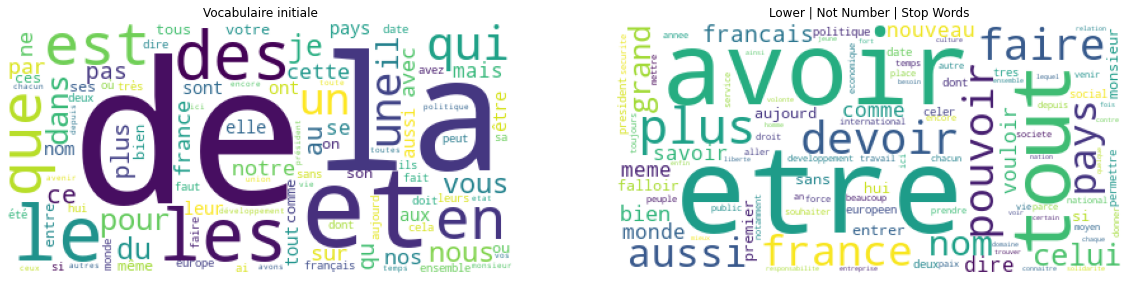

In [16]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

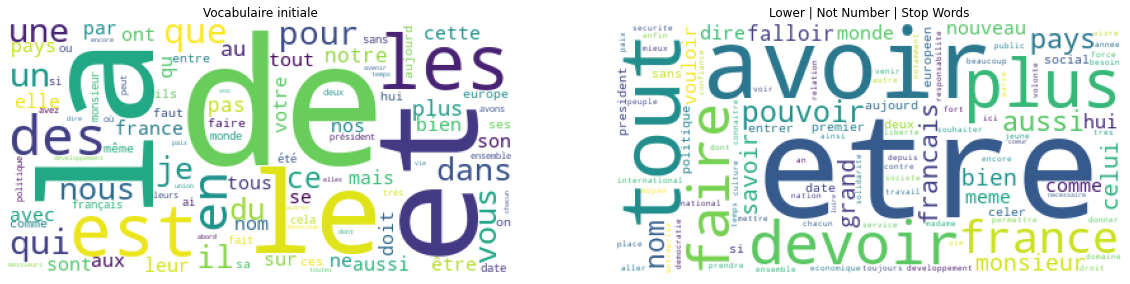

In [17]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=False)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=False)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

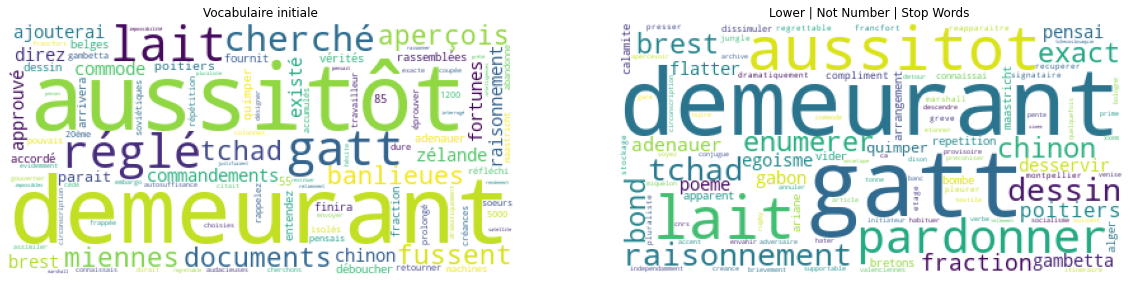

In [18]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True, odd_ratio=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True, odd_ratio=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quelle est la distribution d'apparition des mots (Zipf)

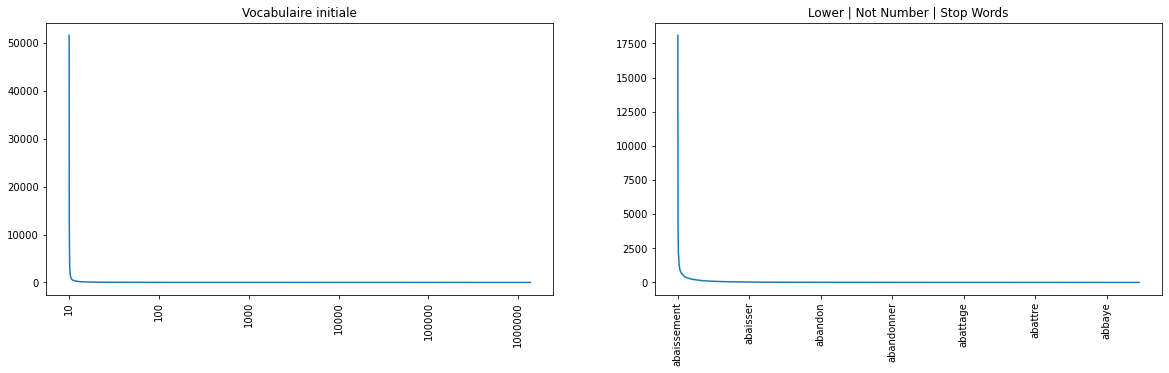

In [19]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

vectors, vectorizer = fit(None, count_vec=True)
counts = np.array(vectors.sum(axis=0))[0]
index = counts.argsort()[::-1]
axs[0].plot(counts[index])
axs[0].set_title('Vocabulaire initiale')
axs[0].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

for i, X in enumerate(strats):
    vectors, vectorizer = fit(X, count_vec=True)
    counts = np.array(vectors.sum(axis=0))[0]
    index = counts.argsort()[::-1]
    axs[i+1].plot(counts[index])
    axs[i+1].set_title(X["name"])
    axs[i+1].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

plt.show()

Quels sont les 100 bigrammes/trigrammes les plus fréquents?

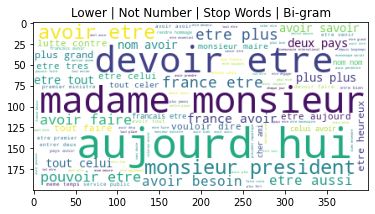

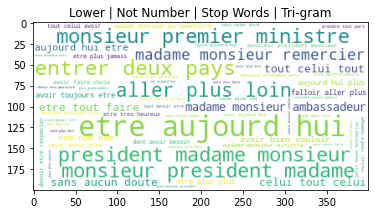

In [20]:
X_bi = {
    "name": "Lower | Not Number | Stop Words | Bi-gram",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "ngram_range": (2, 2),
    "lemmatized": True,
    "count_vec": False,
}

X_tri = {
    "name": "Lower | Not Number | Stop Words | Tri-gram",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "ngram_range": (3, 3),
    "lemmatized": True,
    "count_vec": False,
}

for X in [X_bi, X_tri]:
    wordcloud = get_wordcloud(X, count_vec=False)
    plt.imshow(wordcloud)
    plt.title(X["name"])
    plt.show()

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [21]:
strats.append({
    "name": "Lower | Not Number | Stop Words | TF",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "use_idf": False,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | TF",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "lemmatized": True,
    "count_vec": True,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | min_max_df",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "min_df": 4,
    "max_df": 0.93,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | min_max_df",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "min_df": 4,
    "max_df": 0.95,
    "lemmatized": True,
    "count_vec": True,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | max_features",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "max_features": 10000,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | Binary",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "binary": True,
    "lemmatized": True,
    "count_vec": False,
})

strats.append(X_bi)

strats.append(X_tri)

In [22]:
for X in strats:
    vectors, vectorizer = fit(X, count_vec=X["count_vec"])
    X["base"] = vectors
    X["vectorizer"] = vectorizer

# C) Modèles de Machine Learning

In [23]:
def eval_model(labels, y_hat):
    scores = {}
    scores["f1_score"] = f1_score(labels, y_hat)
    scores["accuracy"] = accuracy_score(labels, y_hat)
    scores["auc_roc"] = roc_auc_score(labels, y_hat)
    return scores

In [24]:
if "Xtest_lem" not in globals():
    Xtest_lem = lemmatize_data(Xtest)

Xtest_lem

array(['je ne aller pas me maintenant sur le autre aspect que je cité : le , le social , culturel ou régional .',
       'dans le , lui pouvoir donner lieu à un application aussi varier que le dépollution un sol , le traitement un eau résiduaire , le mise au point de procédé respectueux de le biosphère ou le développement de de détection et de surveillance un pollution .',
       'il se de renforcer notre concertation politique , lui être bon , mais lui pouvoir encore être améliorer , de donner un nouveau élan à notre relation économique , de en matière social un coopération exemplaire .',
       ...,
       'afin que le décret qui régir ce institution être enrichir , je demander au ministre délégué à le famille de poursuivre le consultation nécessaire .',
       'le être de ne léguer à génération futur que le minimum possible de plutonium et de déchet radioactif à vie long , notamment grâce au tri un déchet réaliser par le retraitement .',
       'pouvoir ce convergence de vue refléte

In [25]:
classes, counts = np.unique(ytest, return_counts=True)
N = counts[np.argmin(counts)]


def balance_classes(X, y, N):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == -1)[0]
    pos_sampled = np.random.choice(pos_indices, N, replace=False)
    neg_sampled = np.random.choice(neg_indices, N, replace=False)
    sampled_indices = np.concatenate([pos_sampled, neg_sampled])
    np.random.shuffle(sampled_indices)
    X_balanced = X[sampled_indices]
    y_balanced = y[sampled_indices]
    return X_balanced, y_balanced


X_balance, Y_balance = balance_classes(Xtest, ytest, N)

In [26]:
def optimize_strats(lstrats, optimizer, model_name):
    for X in tqdm(lstrats):
        X[model_name] = optimizer(X)

In [27]:
def get_scores(lstrats, model_name):
    for X in tqdm(lstrats):
        Xtest_tran = X["vectorizer"].transform(Xtest_lem)
        y_hat = X[model_name].predict(Xtest_tran)
        X[f"scores_{model_name}"] = eval_model(ytest, y_hat)

In [28]:
def get_scores_balanced(lstrats, model_name):
    for X in tqdm(lstrats):
        X_bal_trans = X["vectorizer"].transform(X_balance)
        y_hat = X[model_name].predict(X_bal_trans)
        X[f"scores_{model_name}_balanced"] = eval_model(Y_balance, y_hat)

In [29]:
def lineplot(scores, ax, score_name):
    sns.lineplot(x=list(range(1, len(scores)+1)),
                y=scores, color='steelblue', ax=ax, linestyle='--', marker='o')
    
    ax.set_xlabel('Numéro de la strategie')
    ax.set_ylabel(score_name)
    ax.set_title(f'Distribution des scores {score_name}')

def figure_plot(lstrats, scores_names, fig_name):
    f1_scores = []
    accuracy_scores = []
    roc_auc_scores = []

    for X in lstrats:
        f1_scores.append(X[scores_names]['f1_score'])
        accuracy_scores.append(X[scores_names]['accuracy'])
        roc_auc_scores.append(X[scores_names]['auc_roc'])
        
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(fig_name)
    lineplot(f1_scores, axs[0], "F1 score")
    lineplot(accuracy_scores, axs[1], "Accuracy")
    lineplot(roc_auc_scores, axs[2], "AUC-ROC")
    plt.tight_layout()
    plt.show()
    
def optimization_report(lstrats, model_name):
    figure_plot(lstrats, f"scores_{model_name}", "Pour des classes non equilibrees")
    figure_plot(lstrats, f"scores_{model_name}_balanced", "Pour des classes equilibrees")

In [30]:
classe, count = np.unique(ytrain, return_counts=True)

index_max = np.argmax(count)
index_min = np.argmin(count)

classe_maj = classe[index_max]
classe_min = classe[index_min]

proba = (1 - count / count.sum()) * 100
cout = {classe_maj: proba[index_max], classe_min: proba[index_min]}
cout

{1: 13.102951763858893, -1: 86.8970482361411}

In [31]:
def reglog_optimizer(X, max_iter=1000):
    reglog = LogisticRegression(max_iter=max_iter, class_weight="balanced")
    params = {'C': [0.01, 0.1, 0.5, 1, 2], 'penalty': ['l2', None]}
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    grid = GridSearchCV(reglog, params, cv=cv, n_jobs=-1, scoring='f1_macro')
    grid.fit(X["base"], ytrain)
    
    return grid.best_estimator_

In [32]:
optimize_strats(strats, reglog_optimizer, "reglog")

100%|██████████| 9/9 [02:09<00:00, 14.42s/it]


In [33]:
get_scores(strats, "reglog")

100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


In [34]:
get_scores_balanced(strats, "reglog")

100%|██████████| 9/9 [00:01<00:00,  7.86it/s]


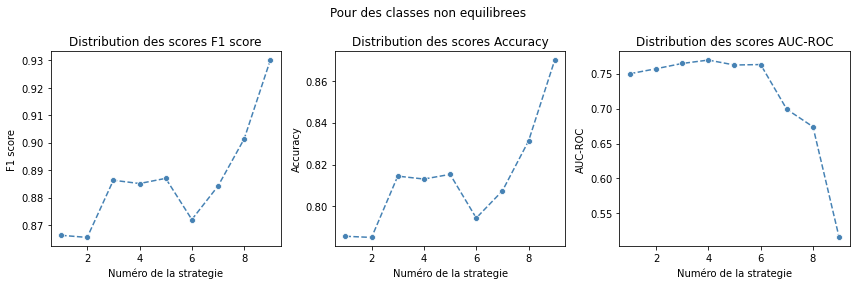

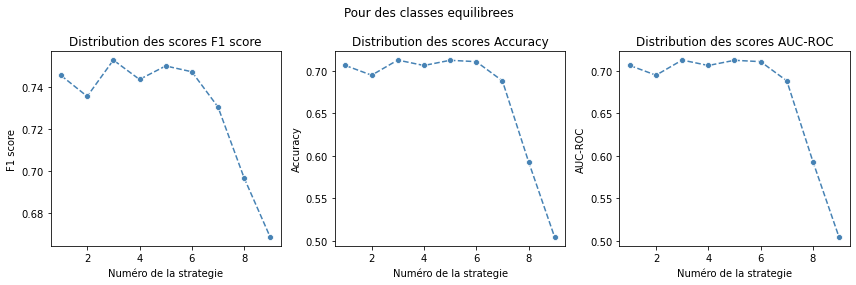

In [35]:
optimization_report(strats, "reglog")

In [36]:
def rf_optimizer(X, n_estimators=100):
    rf = RandomForestClassifier(
        n_estimators=n_estimators, class_weight='balanced')
    params = {'max_depth': [5, 7, 12], 'min_samples_split': [5, 10, 20]}
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    grid = GridSearchCV(rf, params, cv=cv, n_jobs=-1, scoring='f1_macro')
    grid.fit(X["base"], ytrain)

    return grid.best_estimator_

In [51]:
optimize_strats(strats, rf_optimizer, "rf")

100%|██████████| 9/9 [04:34<00:00, 30.54s/it]


In [52]:
get_scores(strats, "rf")

100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


In [53]:
get_scores_balanced(strats, "rf")

100%|██████████| 9/9 [00:01<00:00,  6.81it/s]


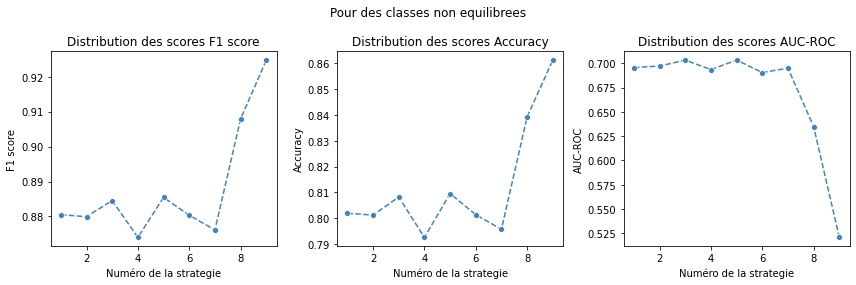

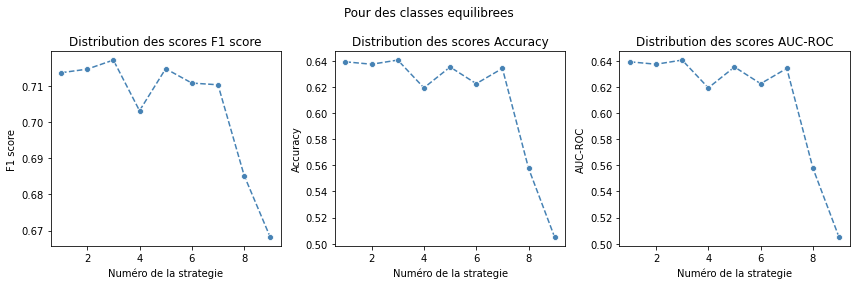

In [54]:
optimization_report(strats, "rf")

In [41]:
def bnb_optimizer(X):
    bnb = BernoulliNB()
    bnb.fit(X["base"], ytrain)
    return bnb

In [42]:
optimize_strats(strats, bnb_optimizer, "bnb")

100%|██████████| 9/9 [00:00<00:00, 92.84it/s]


In [43]:
get_scores(strats, "bnb")

100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


In [44]:
get_scores_balanced(strats, "bnb")

100%|██████████| 9/9 [00:01<00:00,  7.17it/s]


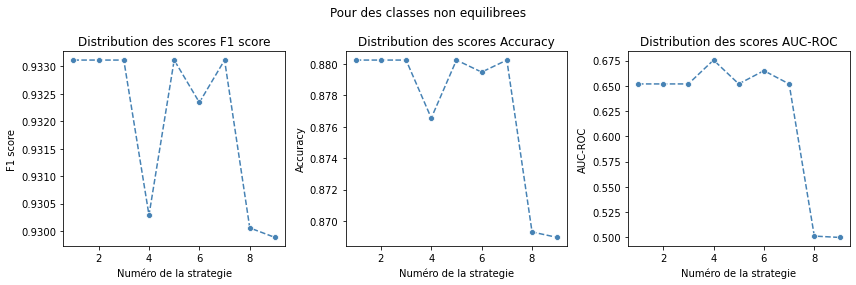

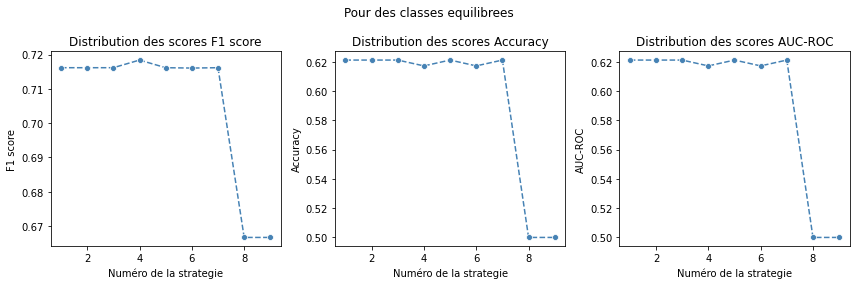

In [45]:
optimization_report(strats, "bnb")

In [46]:
# def svm_optimizer(X):
#     svm = SVC(kernel='rbf', class_weight='balanced')
#     params = {'C': [0.1, 1, 10], 'gamma': [1, 0.1]}
#     cv = StratifiedKFold(n_splits=2, shuffle=True)
    
#     grid = GridSearchCV(svm, params, cv=cv, n_jobs=-1, scoring='f1_macro')
#     grid.fit(X["base"], ytrain)

#     return grid.best_estimator_

In [47]:
# optimize_strats(strats, svm_optimizer, "svm")

In [48]:
# get_scores(strats, "svm")

In [49]:
# get_scores_balanced(strats, "svm")

In [50]:
# optimization_report(strats, "svm")

In [57]:
def load_pres_test(fname):
    alltxts = []
    s = codecs.open(fname, 'r', 'utf-8')  # pour régler le codage
    while True:
        txt = s.readline()
        if (len(txt)) < 5:
            break

        txt = re.sub(r"<[0-9]*:[0-9]*>(.*)", "\\1", txt)
        alltxts.append(txt)

    return np.array(alltxts)

In [58]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.test.utf8"
testtxts = load_pres_test(fname)

In [59]:
testtxts.shape

(27162,)

In [60]:
if "Xval_lem" not in globals():
    Xval_lem = lemmatize_data(testtxts)

Xval_lem

array(['en répondre à votre invitation , en effectuer ce premier visite de de président français en algérie depuis le , je conscience de avec vous un chapitre nouveau de notre histoire commune , le chapitre de le confiance , de le , de respect mutuel , de le et de le solidarité .',
       'et ce moment exceptionnel , je essayer de le concrétiser dans un geste qui être un peu hors de commun : le retour à Alger de sceau de < nom > .',
       'et le musée .', ...,
       'mais , face à enjeu énergétique un pays en décollage économique , nous devoir aller beaucoup plus loin .',
       'le prochain sommet de G8 nous en donne le .',
       'dans ce perspective , je demander à un grand personnalité de le de me faire un proposition sur le moyen de renforcer le coopération scientifique et industriel avec le pays émergent , le transfert de technologie vers ce pays et le financement de son développement propre .'],
      dtype='<U1105')

In [61]:
Ys = []
for X in tqdm(strats):
    Xval_tran = X["vectorizer"].transform(Xval_lem)
    y_hat = X["reglog"].predict(Xval_tran)
    Ys.append(y_hat)

100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


In [68]:
with open("reglog6-v0", "w") as f:
    f.write("\n".join(np.where(Ys[5] == -1, "M", "C")))